## Import libraries and load data

In [28]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
import pandas as pd
import sys
from torch.utils.data import DataLoader

In [29]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

out = np.load('disc-benchmark-files/training-data.npz')
th_train = out['th'] #th[0],th[1],th[2],th[3],...
u_train = out['u'] #u[0],u[1],u[2],u[3],...

data = np.load('disc-benchmark-files/test-simulation-submission-file.npz')
u_test = data['u']
th_test = data['th'] #only the first 50 values are filled the rest are zeros

cuda


## Visualize data

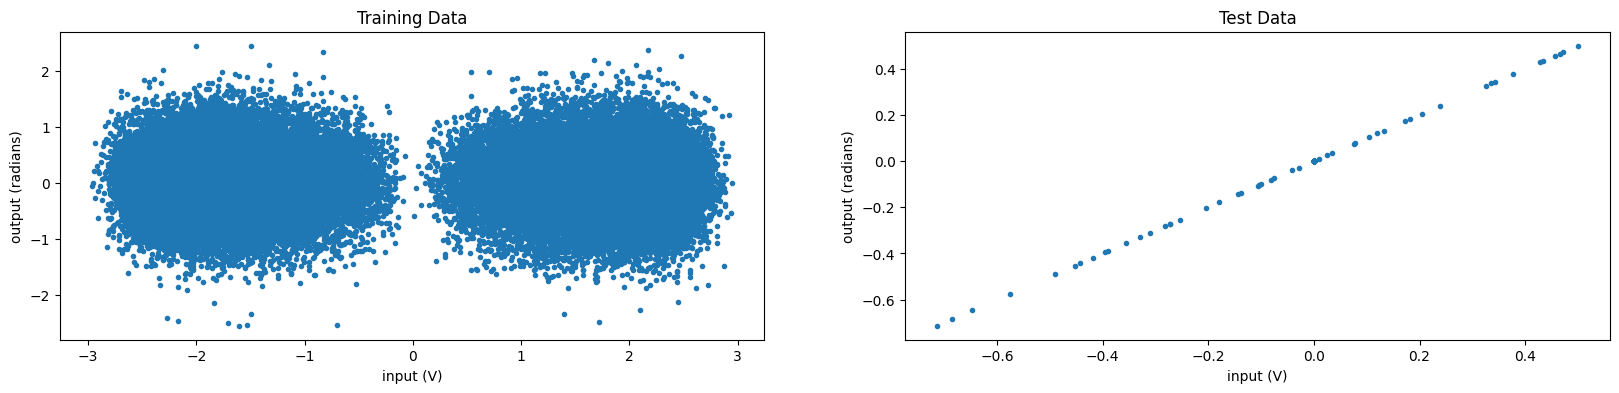

In [30]:
# Plotting the data
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(u_train,th_train,'.')
plt.xlabel('input (V)')
plt.ylabel('output (radians)')
plt.title('Training Data')
plt.subplot(1,2,2)
plt.plot(th_test,th_test,'.')
plt.xlabel('input (V)')
plt.ylabel('output (radians)')
plt.title('Test Data')
plt.show()

## 1. ANN

In [31]:
def create_IO_data(u,y,na,nb):
    X = []
    Y = []
    for k in range(max(na,nb), len(y)):
        X.append(np.concatenate([u[k-nb:k],y[k-na:k]]))
        Y.append(y[k])
    return np.array(X), np.array(Y)

In [32]:
# class Network(nn.Module): 
#     def __init__(self, n_in, n_hidden_nodes): 
#         super(Network,self).__init__() 
#         self.lay1 = nn.Linear(n_in,n_hidden_nodes)
#         self.lay2 = nn.Linear(n_hidden_nodes,n_hidden_nodes)
#         self.lay3 = nn.Linear(n_hidden_nodes,1)
#     def forward(self,x): 
#         x1 = torch.relu(self.lay1(x))
#         x2 = torch.relu(self.lay2(x1))
#         y = self.lay3(x2)
#         return y 

class Network(nn.Module): 
    def __init__(self, n_in, n_hidden_nodes): 
        super(Network,self).__init__() 
        self.lay1 = nn.Linear(n_in,n_hidden_nodes)
        self.lay2 = nn.Linear(n_hidden_nodes,1)
    def forward(self,x): 
        x1 = torch.relu(self.lay1(x)) 
        y = self.lay2(x1)[:,0] 
        return y 

In [33]:
def RMS_NRMS(y_pred, y_truth):
    y_pred = y_pred.detach().cpu()
    y_truth = y_truth.detach().cpu()
    RMS = (torch.mean((y_pred-y_truth)**2))**0.5
    NRMS = RMS/torch.std(y_truth)
    return RMS, NRMS

In [34]:
class Trainer:
    def __init__(self, model, data):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = model.to(self.device)
        self.data = data

        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=1e-4)
        self.critereon = nn.MSELoss()

        assert self.critereon is not None, "You have not defined a loss"
        assert self.optimizer is not None, "You have not defined an optimizer"


    def train_epoch(self, inputs, truths):
            # Put the model in training mode
            self.model.train()

            # Store each step's accuracy and loss for this epoch
            epoch_metrics = {
                "loss": [],
                "RMS": [],
                "NRMS": []
            }

            # Zero the gradients from the previous step
            self.optimizer.zero_grad()

            # Move the inputs and truths to the target device
            inputs = inputs.to(device=self.device)
            truths = truths.to(device=self.device)

            # Run model on the inputs
            output = self.model(inputs)
            
            # Perform backpropagation
            loss = self.critereon(output, truths)
            loss.backward()
            self.optimizer.step()

            # Store the metrics of this step
            step_metrics = {
                'loss': loss.item(),
                'RMS': RMS_NRMS(output, truths)[0],
                'NRMS': RMS_NRMS(output, truths)[1]
            }

            # Add to epoch's metrics
            for k,v in step_metrics.items():
                epoch_metrics[k].append(v)

            # Return metrics
            return epoch_metrics
    
    def val_epoch(self, inputs, truths):
        epoch_metrics = {
                "loss": [],
                "RMS": [],
                "NRMS": []
            }

        # Put the model in evaluation mode
        self.model.eval()
        with torch.no_grad():
            # Move the inputs and truths to the target device
            inputs = inputs.to(device=self.device, dtype=torch.float32)
            truths = truths.to(device=self.device, dtype=torch.float32)

            # Run model on the inputs
            output = self.model(inputs)
            loss = self.critereon(output, truths)

            # Store the metrics of this step
            step_metrics = {
                'loss': loss.item(),
                'RMS': RMS_NRMS(output, truths)[0],
                'NRMS': RMS_NRMS(output, truths)[1]
            }

            # Add to epoch's metrics
            for k,v in step_metrics.items():
                epoch_metrics[k].append(v)

        # Return metrics
        return epoch_metrics
    
    def fit(self, epochs: int):
        # Store metrics of the training process (plot this to gain insight)
        df_train = pd.DataFrame()
        df_val = pd.DataFrame()

        # Train the model for the provided amount of epochs
        for epoch in range(1, epochs+1):
            # print(f'Epoch {epoch}')
            
            metrics_train = self.train_epoch(self.data["Xtrain"],self.data["Ytrain"])
            df_train = pd.concat([df_train,pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_train["loss"]))], **metrics_train})], ignore_index=True)
            
            metrics_val = self.val_epoch(self.data["Xval"],self.data["Yval"])
            df_val = pd.concat([df_val,pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_val["loss"]))], **metrics_val})], ignore_index=True)
            # print(metrics_train["loss"])
            loss_train = metrics_train["loss"]
            loss_val = metrics_val["loss"]
            RMS_val = metrics_val["RMS"]
            NRMS_val = metrics_val["NRMS"]

            if (epoch + 1) % 5000 == 0:
                print('epoch =', epoch+1, 'Train_loss =',loss_train, 'Val_loss =', loss_val, 'Val_RMS =', RMS_val, 'Val_NRMS =', NRMS_val)
        
        # Return a dataframe that logs the training process. This can be exported to a CSV or plotted directly.
        return df_train, df_val
    

    '''mini batch'''
    # def fit(self, epochs: int, batch_size: int):
    #     df_train = pd.DataFrame()
    #     df_val = pd.DataFrame()
    #     num_samples = len(self.data["Xtrain"])
    #     num_batches = num_samples // batch_size

    #     for epoch in range(1, epochs+1):
    #         for batch in range(num_batches):
    #             start_idx = batch * batch_size
    #             end_idx = (batch + 1) * batch_size

    #             batch_X = self.data["Xtrain"][start_idx:end_idx]
    #             batch_Y = self.data["Ytrain"][start_idx:end_idx]

    #             metrics_train = self.train_epoch(batch_X, batch_Y)
    #             df_train = pd.concat([df_train, pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_train["loss"]))], **metrics_train})], ignore_index=True)

    #             metrics_val = self.val_epoch(self.data["Xval"], self.data["Yval"])
    #             df_val = pd.concat([df_val, pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_val["loss"]))], **metrics_val})], ignore_index=True)

    #             loss_train = metrics_train["loss"]
    #             loss_val = metrics_val["loss"]
    #             RMS_val = metrics_val["RMS"]
    #             NRMS_val = metrics_val["NRMS"]

    #         if (epoch + 1) % 2 == 0:
    #             print('epoch =', epoch+1, 'Train_loss =', loss_train, 'Val_loss =', loss_val, 'Val_RMS =', RMS_val, 'Val_NRMS =', NRMS_val)

    #     return df_train, df_val


        

## tunning


In [35]:
import random

list1 = [x for x in range(0, 22) if x % 2 == 0]
list2 = [x for x in range(0, 22) if x % 2 == 0]
results = []

# using random layout near origin good selection
while len(results) < 20:
    # select randomly
    num1 = random.choice(list1)
    num2 = random.choice(list2)
    result = (num1, num2)
    
    # if it is not selected, add it
    if result not in results:
        results.append(result)

print(results)

[(18, 2), (18, 20), (4, 8), (0, 6), (16, 14), (18, 16), (10, 0), (16, 18), (12, 0), (4, 14), (20, 6), (14, 2), (2, 4), (16, 10), (6, 10), (10, 20), (12, 20), (20, 2), (0, 16), (14, 4)]


In [36]:
device="cuda" if torch.cuda.is_available() else "cpu"

loss = []
RMS = []
NRMS = []

for i in range(len(results)):
    val_RMS = []
    val_NRMS = []
    val_Loss = []
    na, nb = results[i]

    # generate data
    Xdata, Ydata = create_IO_data(u_train, th_train, na, nb)  # For training data
    Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata,Ydata)
    Xtrain, Xval, Ytrain, Yval = [torch.as_tensor(x).to(device=device, dtype=torch.float32) for x in [Xtrain, Xval, Ytrain, Yval]]

    data = {
        "Xtrain": Xtrain,
        "Xval": Xval,
        "Ytrain": Ytrain,
        "Yval": Yval
    }

    # free memory
    torch.cuda.empty_cache()

    # Train the passthrough network
    print("Testing training process: ", i, f'(na = {results[i][0]}, nb = {results[i][1]})')
    model = Network(na + nb, n_hidden_nodes = 64)

    epochs = 20000
    trainer = Trainer(model, data)
    train_resluts, validation_results = trainer.fit(epochs=epochs)

    # save loss, RMS, NRMS
    painted = 'loss'
    for j in range(1,validation_results['epoch'].max()):
        val_Loss.append(validation_results[validation_results['epoch']==j][painted].mean(0))
    loss.append(val_Loss)
    
    painted = 'RMS'
    for i in range(1,validation_results['epoch'].max()):
        val_RMS.append(validation_results[validation_results['epoch']==i][painted].mean(0))
    RMS.append(val_RMS)

    painted = 'NRMS'
    for k in range(1,validation_results['epoch'].max()):
        val_NRMS.append(validation_results[validation_results['epoch']==k][painted].mean(0))
    NRMS.append(val_NRMS)


Testing training process:  0 (na = 18, nb = 2)
epoch = 5000 Train_loss = [0.0005438579828478396] Val_loss = [0.000544754380825907] Val_RMS = [tensor(0.0233)] Val_NRMS = [tensor(0.0476)]
epoch = 10000 Train_loss = [5.816379052703269e-05] Val_loss = [6.008510899846442e-05] Val_RMS = [tensor(0.0078)] Val_NRMS = [tensor(0.0158)]
epoch = 15000 Train_loss = [1.8413007637718692e-05] Val_loss = [1.9839897504425608e-05] Val_RMS = [tensor(0.0045)] Val_NRMS = [tensor(0.0091)]
epoch = 20000 Train_loss = [1.3341316844162066e-05] Val_loss = [1.4686680515296757e-05] Val_RMS = [tensor(0.0038)] Val_NRMS = [tensor(0.0078)]
Testing training process:  1 (na = 18, nb = 20)
epoch = 5000 Train_loss = [0.0009391825878992677] Val_loss = [0.0010096923215314746] Val_RMS = [tensor(0.0318)] Val_NRMS = [tensor(0.0651)]
epoch = 10000 Train_loss = [3.8205544115044177e-05] Val_loss = [4.3276810174575076e-05] Val_RMS = [tensor(0.0066)] Val_NRMS = [tensor(0.0135)]
epoch = 15000 Train_loss = [1.4573055523214862e-05] Val_

In [37]:
from pathlib import Path

# create folder
folder_name = 'ANN_tunning'
p_model = (Path()/'Train'/folder_name)
p_model.mkdir(parents=True, exist_ok=True)

# save dataframe file
pd.DataFrame(loss).to_csv((p_model/f"loss.csv"))
pd.DataFrame(RMS).to_csv((p_model/f"RMS.csv"))
pd.DataFrame(NRMS).to_csv((p_model/f"NRMS.csv"))

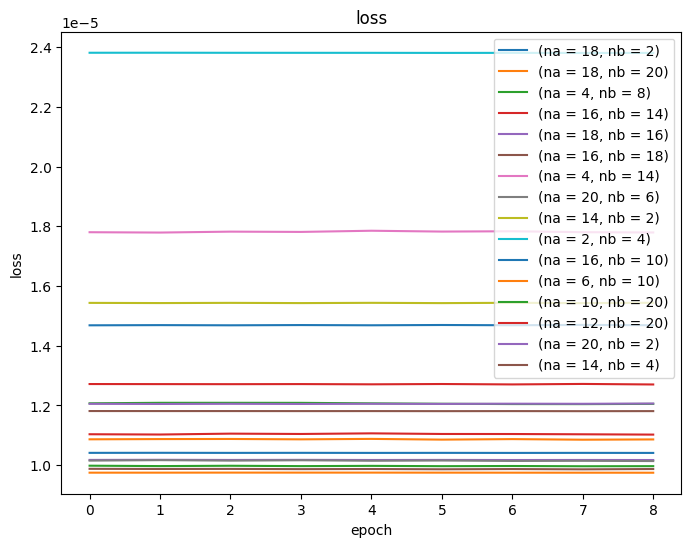

<Figure size 640x480 with 0 Axes>

In [49]:
plt.figure(figsize=(8, 6))
painted = 'loss'
for i in range(len(loss)):
    label = f'(na = {results[i][0]}, nb = {results[i][1]})'
    if np.min(loss[i][19990:20000])<0.0002:
        plt.plot(loss[i][19990:20000],label=label)
plt.title(painted)
plt.ylabel(painted)
plt.xlabel('epoch')
plt.legend()
plt.show()

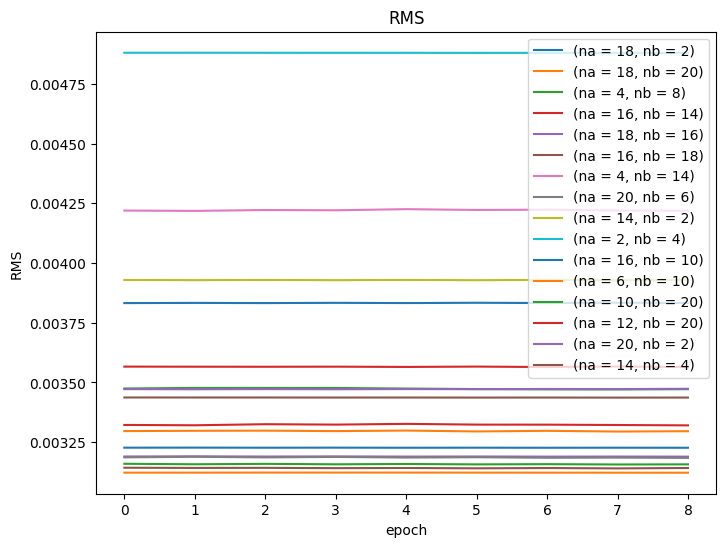

<Figure size 640x480 with 0 Axes>

In [54]:
plt.figure(figsize=(8, 6))
painted = 'RMS'
for i in range(len(RMS)):
    label = f'(na = {results[i][0]}, nb = {results[i][1]})'
    if np.min(RMS[i][19990:20000])<0.006:
        plt.plot(RMS[i][19990:20000],label=label)
plt.title(painted)
plt.ylabel(painted)
plt.xlabel('epoch')
plt.legend()
plt.show()

pic_name = f"RMS_tunning.png"
plt.savefig((p_model/pic_name))

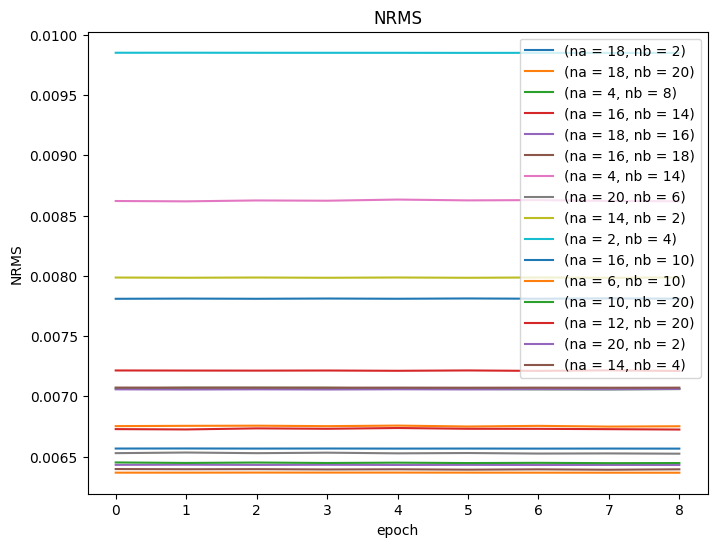

<Figure size 640x480 with 0 Axes>

In [58]:
plt.figure(figsize=(8, 6))
painted = 'NRMS'
for i in range(len(NRMS)):
    label = f'(na = {results[i][0]}, nb = {results[i][1]})'
    if np.min(NRMS[i][19990:20000])<0.01:
        plt.plot(NRMS[i][19990:20000],label=label)
    # plt.plot(NRMS[i],label=label)
plt.title(painted)
plt.ylabel(painted)
plt.xlabel('epoch')
plt.legend()
plt.show()

pic_name = f"NRMS_tunning.png"
plt.savefig((p_model/pic_name))